## Importación de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import albumentations as A
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Configuración de rutas y parámetros

In [2]:
ruta_base = Path('/home/zamirlm/Documents/Utec/Ciclo2025-2/ML-PROYECTOS/P3-EcoSort')
ruta_train = ruta_base / 'data' / 'preprocessed' / 'train'
ruta_val = ruta_base / 'data' / 'preprocessed' / 'val'
ruta_features = ruta_base / 'result' / 'features'
ruta_figuras = ruta_base / 'result' / 'figures'

clases = ['general', 'paper', 'plastic']
etiquetas_map = {'general': 0, 'paper': 1, 'plastic': 2}

tamanio_imagen = (128, 128)
objetivo_train = 10000

## 1. Normalización y preprocesamiento

### 1.1 Función de carga y normalización

In [3]:
def cargar_y_normalizar_imagen(ruta_imagen, tamanio):
    img = cv2.imread(str(ruta_imagen))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, tamanio)
    img_normalizada = img.astype(np.float32) / 255.0
    return img_normalizada, img

## 2. Data Augmentation

### 2.1 Configuración de transformaciones

In [4]:
transformaciones = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=20, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
    A.Blur(blur_limit=3, p=0.2)
])

### 2.2 Función de augmentación

In [5]:
def aplicar_augmentation(imagen):
    imagen_uint8 = (imagen * 255).astype(np.uint8)
    augmentada = transformaciones(image=imagen_uint8)
    imagen_augmentada = augmentada['image'].astype(np.float32) / 255.0
    return imagen_augmentada

### 2.3 Visualización de augmentation

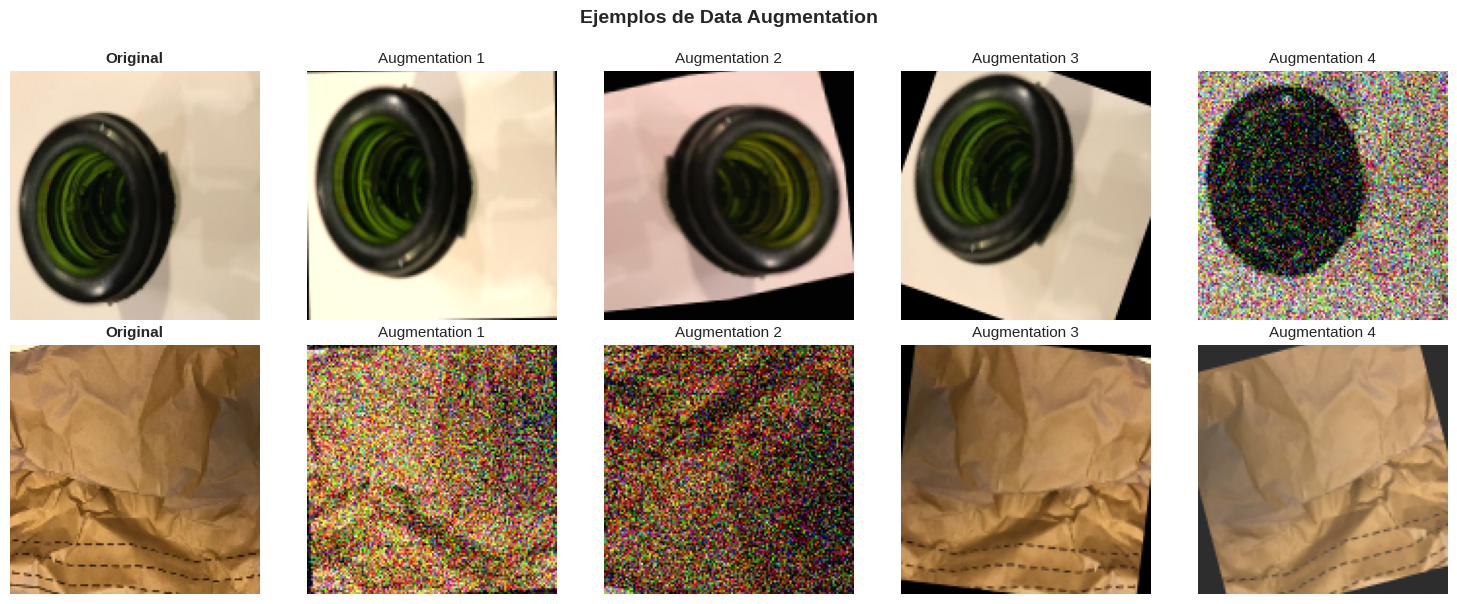

In [6]:
archivos_ejemplo = list((ruta_train / 'general').glob('*.jpg'))
img_original, img_original_uint8 = cargar_y_normalizar_imagen(archivos_ejemplo[0], tamanio_imagen)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes[0, 0].imshow(img_original)
axes[0, 0].set_title('Original', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

for i in range(1, 5):
    img_aug = aplicar_augmentation(img_original)
    axes[0, i].imshow(img_aug)
    axes[0, i].set_title(f'Augmentation {i}', fontsize=11)
    axes[0, i].axis('off')

archivos_ejemplo = list((ruta_train / 'paper').glob('*.jpg'))
img_original, img_original_uint8 = cargar_y_normalizar_imagen(archivos_ejemplo[0], tamanio_imagen)

axes[1, 0].imshow(img_original)
axes[1, 0].set_title('Original', fontsize=11, fontweight='bold')
axes[1, 0].axis('off')

for i in range(1, 5):
    img_aug = aplicar_augmentation(img_original)
    axes[1, i].imshow(img_aug)
    axes[1, i].set_title(f'Augmentation {i}', fontsize=11)
    axes[1, i].axis('off')

plt.suptitle('Ejemplos de Data Augmentation', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(ruta_figuras / '02_fe_01_augmentation_ejemplos.svg', format='svg', bbox_inches='tight')
plt.show()

### 2.4 Generación de dataset aumentado

In [7]:
def generar_dataset_aumentado(ruta_dataset, objetivo_total, aplicar_aug=True):
    imagenes = []
    etiquetas = []
    
    for clase in clases:
        ruta_clase = ruta_dataset / clase
        archivos = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.jpeg')) + list(ruta_clase.glob('*.png'))
        
        num_originales = len(archivos)
        objetivo_por_clase = objetivo_total // len(clases)
        num_augmentaciones = max(0, objetivo_por_clase - num_originales)
        
        for archivo in tqdm(archivos, desc=f'Cargando {clase}'):
            try:
                img_norm, _ = cargar_y_normalizar_imagen(archivo, tamanio_imagen)
                imagenes.append(img_norm)
                etiquetas.append(etiquetas_map[clase])
            except Exception as e:
                continue
        
        if aplicar_aug and num_augmentaciones > 0:
            for _ in tqdm(range(num_augmentaciones), desc=f'Augmentation {clase}'):
                archivo_random = np.random.choice(archivos)
                try:
                    img_norm, _ = cargar_y_normalizar_imagen(archivo_random, tamanio_imagen)
                    img_aug = aplicar_augmentation(img_norm)
                    imagenes.append(img_aug)
                    etiquetas.append(etiquetas_map[clase])
                except Exception as e:
                    continue
    
    return np.array(imagenes), np.array(etiquetas)

X_train, y_train = generar_dataset_aumentado(ruta_train, objetivo_train, aplicar_aug=True)
X_val, y_val = generar_dataset_aumentado(ruta_val, objetivo_total=5000, aplicar_aug=False)

Cargando general:   0%|          | 0/838 [00:00<?, ?it/s]

Cargando plastic: 100%|██████████| 97/97 [00:00<00:00, 613.50it/s]


In [8]:
resumen_dataset = pd.DataFrame({
    'Dataset': ['Train', 'Val'],
    'Total imágenes': [len(X_train), len(X_val)],
    'Shape': [str(X_train.shape), str(X_val.shape)]
})
resumen_dataset

,Dataset,Total imágenes,Shape
0,Train,9999,"(9999, 128, 128, 3)"
1,Val,507,"(507, 128, 128, 3)"


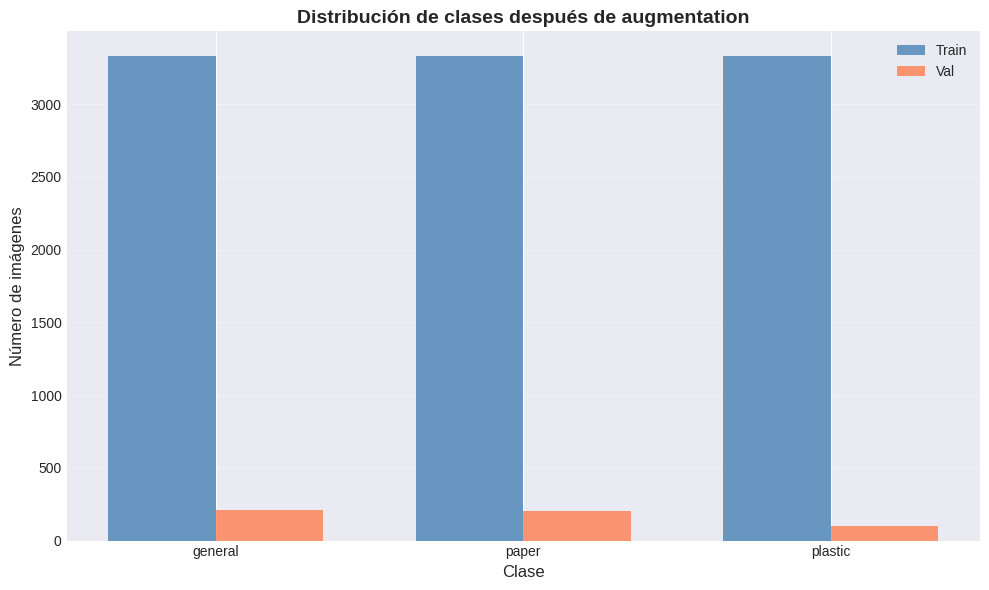

In [9]:
distribucion_train = pd.Series(y_train).value_counts().sort_index()
distribucion_val = pd.Series(y_val).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(clases))
ancho = 0.35

ax.bar(x - ancho/2, distribucion_train.values, ancho, label='Train', alpha=0.8, color='steelblue')
ax.bar(x + ancho/2, distribucion_val.values, ancho, label='Val', alpha=0.8, color='coral')

ax.set_xlabel('Clase', fontsize=12)
ax.set_ylabel('Número de imágenes', fontsize=12)
ax.set_title('Distribución de clases después de augmentation', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(clases)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_figuras / '02_fe_02_distribucion_post_augmentation.svg', format='svg', bbox_inches='tight')
plt.show()

## 3. Extracción de características

### 3.1 Extracción de características HOG

In [10]:
def extraer_hog(imagen):
    imagen_gris = cv2.cvtColor((imagen * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    features_hog = hog(
        imagen_gris,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return features_hog

### 3.2 Visualización de HOG

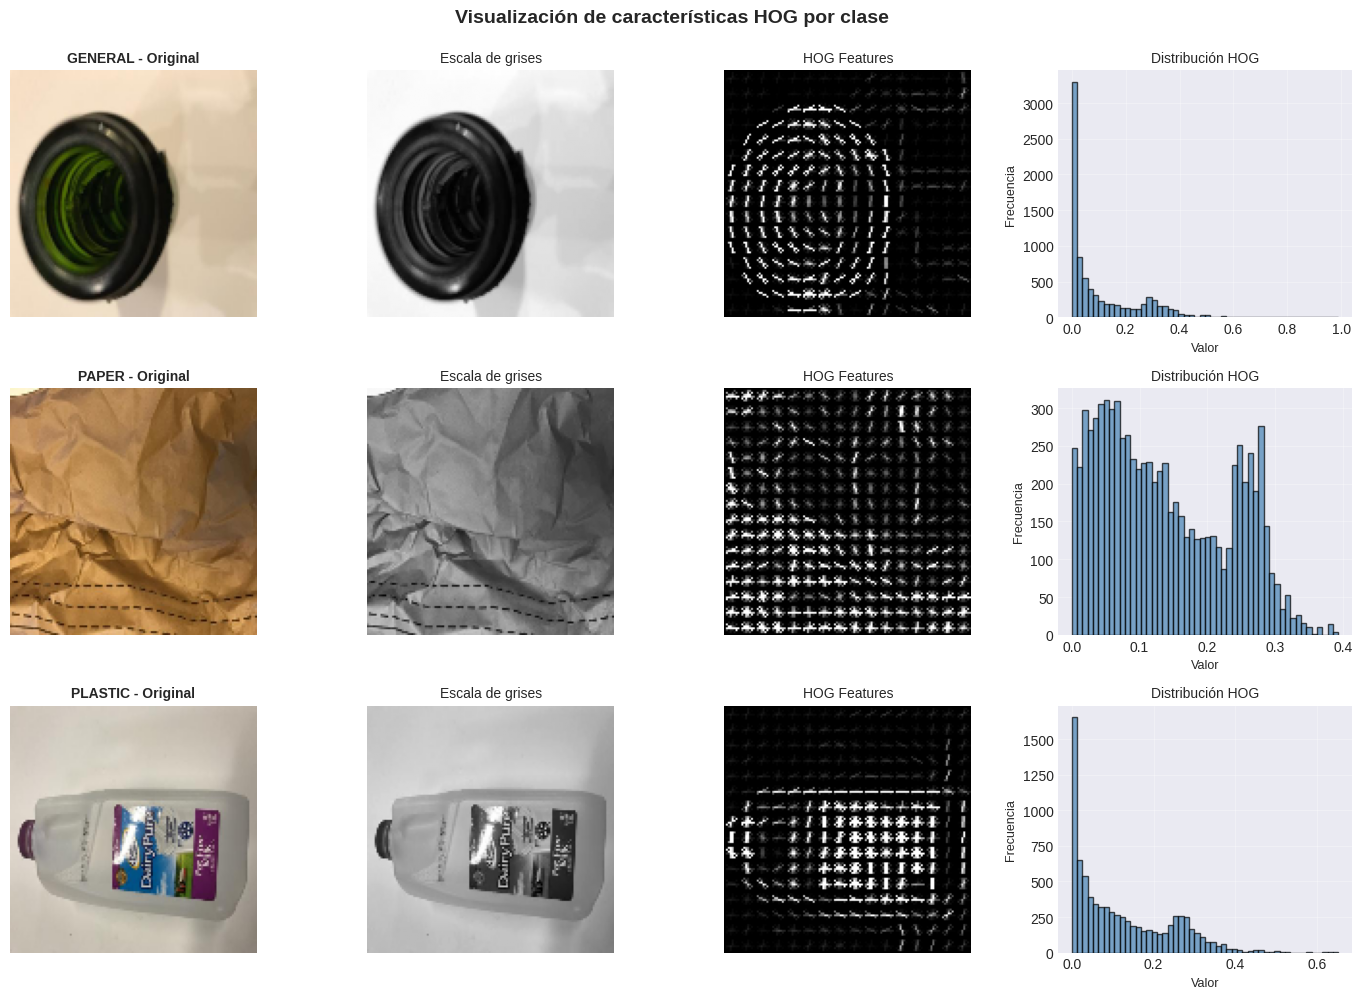

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

for i, clase in enumerate(clases):
    idx_clase = np.where(y_train == etiquetas_map[clase])[0][0]
    img = X_train[idx_clase]
    img_gris = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    features_hog, hog_image = hog(
        img_gris,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'{clase.upper()} - Original', fontsize=10, fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(img_gris, cmap='gray')
    axes[i, 1].set_title('Escala de grises', fontsize=10)
    axes[i, 1].axis('off')
    
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    axes[i, 2].imshow(hog_image_rescaled, cmap='gray')
    axes[i, 2].set_title('HOG Features', fontsize=10)
    axes[i, 2].axis('off')
    
    axes[i, 3].hist(features_hog, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[i, 3].set_title('Distribución HOG', fontsize=10)
    axes[i, 3].set_xlabel('Valor', fontsize=9)
    axes[i, 3].set_ylabel('Frecuencia', fontsize=9)
    axes[i, 3].grid(alpha=0.3)

plt.suptitle('Visualización de características HOG por clase', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(ruta_figuras / '02_fe_03_hog_visualizacion.svg', format='svg', bbox_inches='tight')
plt.show()

### 3.3 Extracción de características de color

In [12]:
def extraer_caracteristicas_color(imagen):
    img_uint8 = (imagen * 255).astype(np.uint8)
    
    hist_rgb = []
    for canal in range(3):
        hist = cv2.calcHist([img_uint8], [canal], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_rgb.extend(hist)
    
    img_hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    hist_hsv = []
    for canal in range(3):
        hist = cv2.calcHist([img_hsv], [canal], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_hsv.extend(hist)
    
    img_lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    hist_lab = []
    for canal in range(3):
        hist = cv2.calcHist([img_lab], [canal], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_lab.extend(hist)
    
    momentos_rgb = []
    for canal in range(3):
        momentos = cv2.moments(img_uint8[:, :, canal])
        momentos_rgb.extend([momentos['mu20'], momentos['mu11'], momentos['mu02']])
    
    features_color = np.concatenate([hist_rgb, hist_hsv, hist_lab, momentos_rgb])
    return features_color

### 3.4 Visualización de características de color

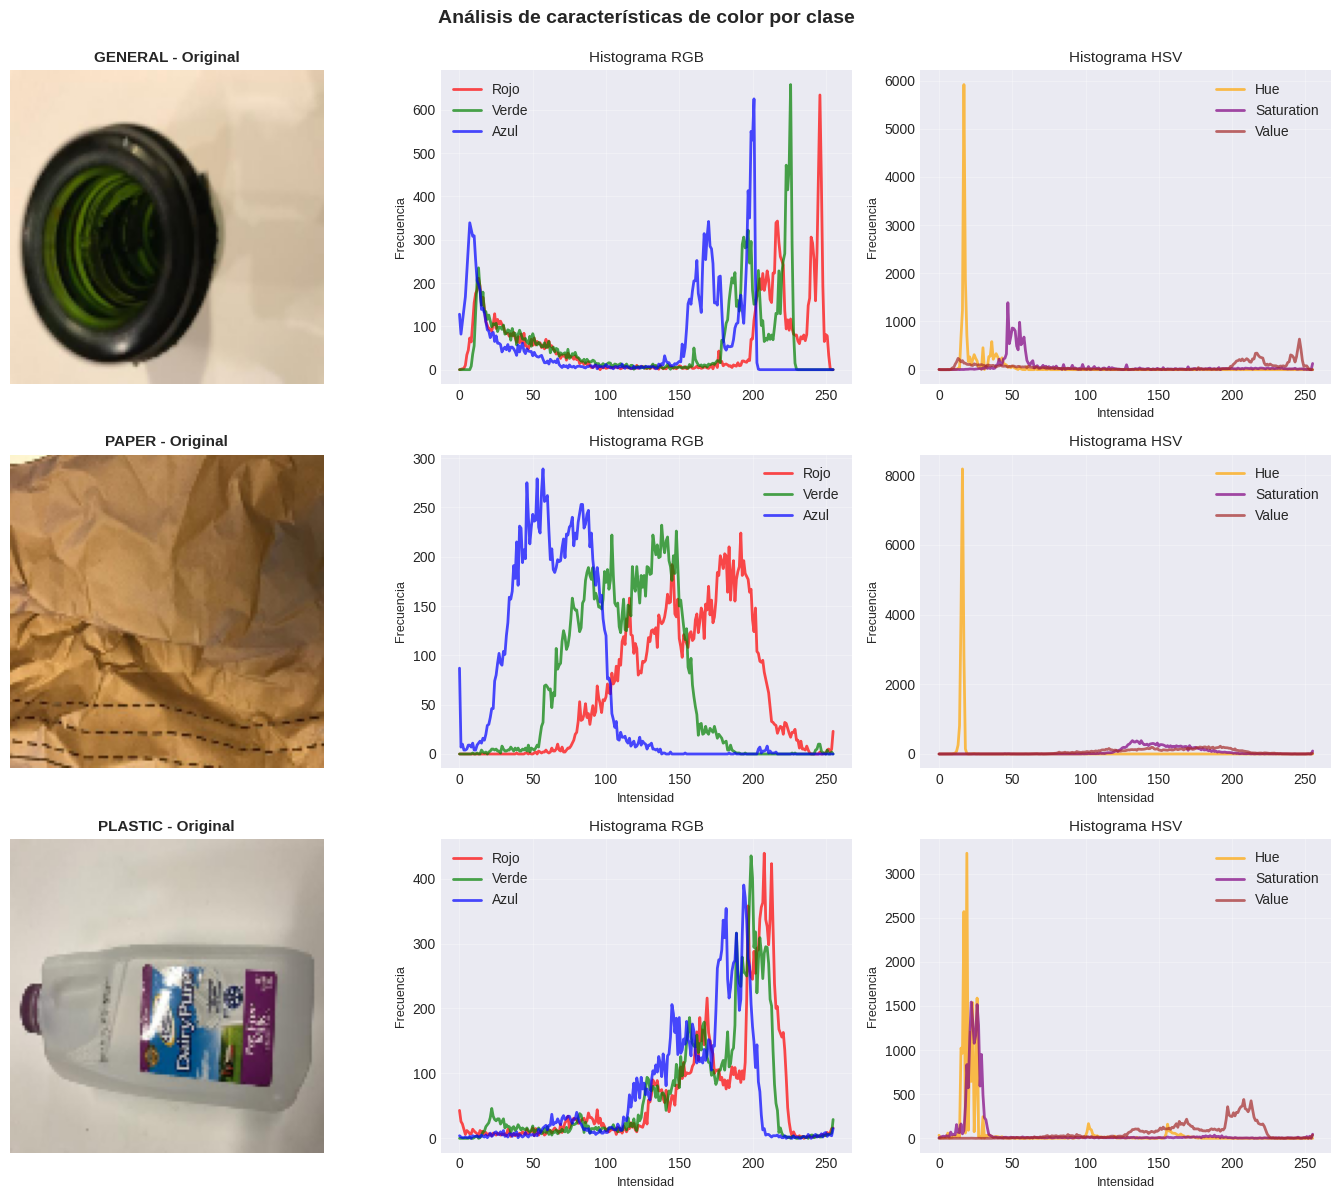

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12))

for i, clase in enumerate(clases):
    idx_clase = np.where(y_train == etiquetas_map[clase])[0][0]
    img = X_train[idx_clase]
    img_uint8 = (img * 255).astype(np.uint8)
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'{clase.upper()} - Original', fontsize=11, fontweight='bold')
    axes[i, 0].axis('off')
    
    colores = ('r', 'g', 'b')
    nombres_canales = ('Rojo', 'Verde', 'Azul')
    for j, (color, nombre) in enumerate(zip(colores, nombres_canales)):
        hist = cv2.calcHist([img_uint8], [j], None, [256], [0, 256])
        axes[i, 1].plot(hist, color=color, label=nombre, alpha=0.7, linewidth=2)
    axes[i, 1].set_title('Histograma RGB', fontsize=11)
    axes[i, 1].set_xlabel('Intensidad', fontsize=9)
    axes[i, 1].set_ylabel('Frecuencia', fontsize=9)
    axes[i, 1].legend()
    axes[i, 1].grid(alpha=0.3)
    
    img_hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    colores_hsv = ('orange', 'purple', 'brown')
    nombres_hsv = ('Hue', 'Saturation', 'Value')
    for j, (color, nombre) in enumerate(zip(colores_hsv, nombres_hsv)):
        hist = cv2.calcHist([img_hsv], [j], None, [256], [0, 256])
        axes[i, 2].plot(hist, color=color, label=nombre, alpha=0.7, linewidth=2)
    axes[i, 2].set_title('Histograma HSV', fontsize=11)
    axes[i, 2].set_xlabel('Intensidad', fontsize=9)
    axes[i, 2].set_ylabel('Frecuencia', fontsize=9)
    axes[i, 2].legend()
    axes[i, 2].grid(alpha=0.3)

plt.suptitle('Análisis de características de color por clase', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(ruta_figuras / '02_fe_04_color_visualizacion.svg', format='svg', bbox_inches='tight')
plt.show()

## 4. Fusión de características

### 4.1 Extracción y combinación de todas las características

In [14]:
def extraer_todas_caracteristicas(imagenes):
    features_hog_lista = []
    features_color_lista = []
    
    for img in tqdm(imagenes, desc='Extrayendo características'):
        hog_feat = extraer_hog(img)
        color_feat = extraer_caracteristicas_color(img)
        
        features_hog_lista.append(hog_feat)
        features_color_lista.append(color_feat)
    
    features_hog = np.array(features_hog_lista)
    features_color = np.array(features_color_lista)
    features_combinadas = np.concatenate([features_hog, features_color], axis=1)
    
    return features_hog, features_color, features_combinadas

hog_train, color_train, features_train = extraer_todas_caracteristicas(X_train)
hog_val, color_val, features_val = extraer_todas_caracteristicas(X_val)

Extrayendo características: 100%|██████████| 507/507 [00:02<00:00, 192.09it/s]


In [15]:
resumen_features = pd.DataFrame({
    'Tipo de característica': ['HOG', 'Color', 'Combinadas'],
    'Dimensiones Train': [hog_train.shape[1], color_train.shape[1], features_train.shape[1]],
    'Dimensiones Val': [hog_val.shape[1], color_val.shape[1], features_val.shape[1]]
})
resumen_features

,Tipo de característica,Dimensiones Train,Dimensiones Val
0,HOG,8100,8100
1,Color,297,297
2,Combinadas,8397,8397


### 4.2 Validación con Logistic Regression

In [16]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_val_scaled = scaler.transform(features_val)

modelo_logistic = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
modelo_logistic.fit(features_train_scaled, y_train)

y_pred_train = modelo_logistic.predict(features_train_scaled)
y_pred_val = modelo_logistic.predict(features_val_scaled)

acc_train = accuracy_score(y_train, y_pred_train)
acc_val = accuracy_score(y_val, y_pred_val)

KeyboardInterrupt: 

In [ ]:
validacion_resultados = pd.DataFrame({
    'Métrica': ['Accuracy Train', 'Accuracy Val'],
    'Valor': [f'{acc_train:.4f}', f'{acc_val:.4f}']
})
validacion_resultados

,Métrica,Valor
0,Accuracy Train,0.9999
1,Accuracy Val,0.6469


In [ ]:
reporte = classification_report(y_val, y_pred_val, target_names=clases, output_dict=True)
df_reporte = pd.DataFrame(reporte).transpose()
df_reporte = df_reporte.round(4)
df_reporte

,precision,recall,f1-score,support
general,0.6763,0.6667,0.6715,210.0000
paper,0.7287,0.6850,0.7062,200.0000
plastic,0.4554,0.5258,0.4880,97.0000
accuracy,0.6469,0.6469,0.6469,0.6469
macro avg,0.6201,0.6258,0.6219,507.0000
weighted avg,0.6547,0.6469,0.6501,507.0000


## 5. Reducción de dimensionalidad con PCA

### 5.1 Aplicación de PCA

In [ ]:
pca = PCA(n_components=0.95, random_state=42)
features_train_pca = pca.fit_transform(features_train_scaled)
features_val_pca = pca.transform(features_val_scaled)

varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
num_componentes = pca.n_components_

In [ ]:
info_pca = pd.DataFrame({
    'Métrica': ['Dimensiones originales', 'Componentes PCA (95% varianza)', 'Varianza explicada', 'Reducción dimensionalidad'],
    'Valor': [
        features_train.shape[1],
        num_componentes,
        f'{varianza_acumulada[-1]:.4f}',
        f'{(1 - num_componentes/features_train.shape[1])*100:.2f}%'
    ]
})
info_pca

,Métrica,Valor
0,Dimensiones originales,8397
1,Componentes PCA (95% varianza),1932
2,Varianza explicada,0.9500
3,Reducción dimensionalidad,76.99%


### 5.2 Visualización de varianza explicada

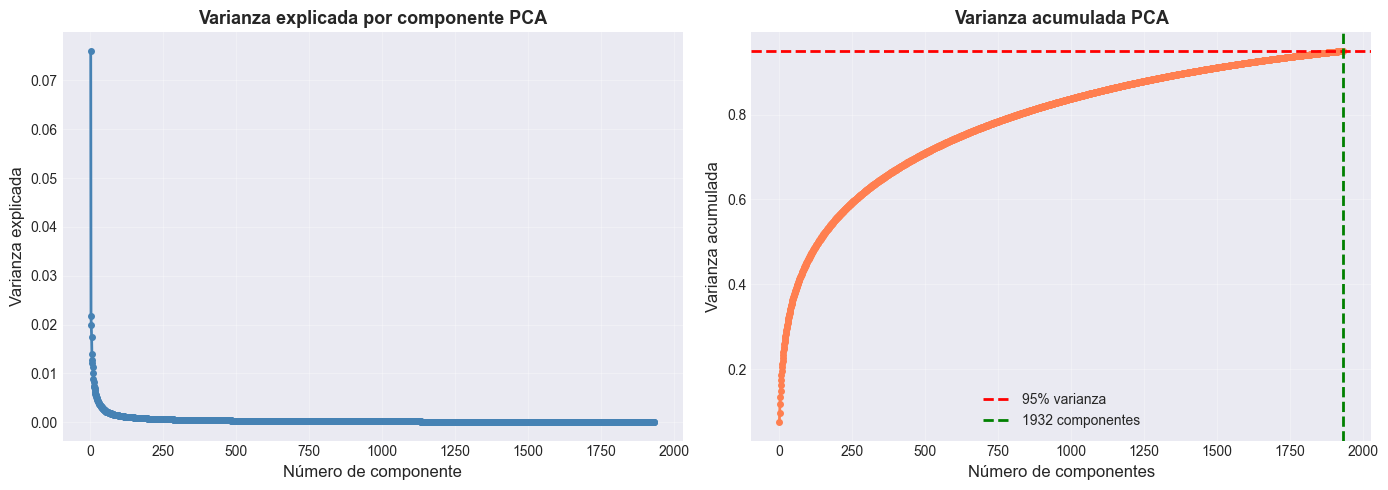

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-', linewidth=2, markersize=4, color='steelblue')
axes[0].set_xlabel('Número de componente', fontsize=12)
axes[0].set_ylabel('Varianza explicada', fontsize=12)
axes[0].set_title('Varianza explicada por componente PCA', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, 'o-', linewidth=2, markersize=4, color='coral')
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% varianza')
axes[1].axvline(x=num_componentes, color='green', linestyle='--', linewidth=2, label=f'{num_componentes} componentes')
axes[1].set_xlabel('Número de componentes', fontsize=12)
axes[1].set_ylabel('Varianza acumulada', fontsize=12)
axes[1].set_title('Varianza acumulada PCA', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_figuras / '02_fe_05_pca_varianza.svg', format='svg', bbox_inches='tight')
plt.show()

### 5.3 Visualización de características PCA en 2D

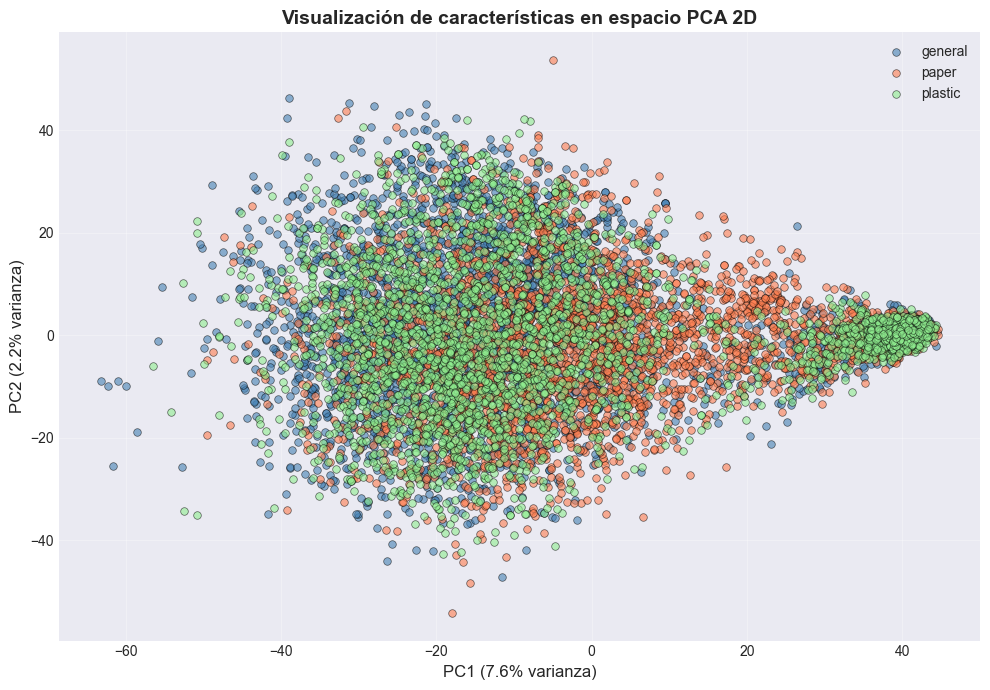

In [ ]:
pca_2d = PCA(n_components=2, random_state=42)
features_2d = pca_2d.fit_transform(features_train_scaled)

fig, ax = plt.subplots(figsize=(10, 7))

colores_plot = ['steelblue', 'coral', 'lightgreen']
for i, clase in enumerate(clases):
    indices = y_train == i
    ax.scatter(features_2d[indices, 0], features_2d[indices, 1], 
               alpha=0.6, label=clase, s=30, c=colores_plot[i], edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% varianza)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% varianza)', fontsize=12)
ax.set_title('Visualización de características en espacio PCA 2D', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_figuras / '02_fe_06_pca_2d_visualizacion.svg', format='svg', bbox_inches='tight')
plt.show()

## 6. Almacenamiento de características procesadas

In [ ]:
np.save(ruta_features / 'X_train_imagenes.npy', X_train)
np.save(ruta_features / 'X_val_imagenes.npy', X_val)
np.save(ruta_features / 'y_train.npy', y_train)
np.save(ruta_features / 'y_val.npy', y_val)

np.save(ruta_features / 'features_train_combinadas.npy', features_train)
np.save(ruta_features / 'features_val_combinadas.npy', features_val)
np.save(ruta_features / 'features_train_pca.npy', features_train_pca)
np.save(ruta_features / 'features_val_pca.npy', features_val_pca)

joblib.dump(scaler, ruta_features / 'scaler.pkl')
joblib.dump(pca, ruta_features / 'pca_model.pkl')

['e:\\06. Sexto Ciclo\\01. Machine Learning\\07. Workspace\\16S03. Proyecto 03\\P3-EcoSort\\result\\features\\pca_model.pkl']

In [ ]:
archivos_guardados = [
    'X_train_imagenes.npy',
    'X_val_imagenes.npy',
    'y_train.npy',
    'y_val.npy',
    'features_train_combinadas.npy',
    'features_val_combinadas.npy',
    'features_train_pca.npy',
    'features_val_pca.npy',
    'scaler.pkl',
    'pca_model.pkl'
]

resumen_archivos = pd.DataFrame({
    'Archivo': archivos_guardados,
    'Guardado': ['✓'] * len(archivos_guardados)
})
resumen_archivos

,Archivo,Guardado
0,X_train_imagenes.npy,✓
1,X_val_imagenes.npy,✓
2,y_train.npy,✓
3,y_val.npy,✓
4,features_train_combinadas.npy,✓
5,features_val_combinadas.npy,✓
6,features_train_pca.npy,✓
7,features_val_pca.npy,✓
8,scaler.pkl,✓
9,pca_model.pkl,✓


## Resumen del Feature Engineering

Se completaron exitosamente las siguientes etapas:

**1. Normalización y preprocesamiento:**
- Redimensionamiento a tamaño fijo de 128x128 píxeles
- Normalización de valores de píxeles a rango [0, 1]

**2. Data Augmentation:**
- Aplicación de 8 técnicas de augmentation diferentes
- Generación de dataset balanceado con mínimo 10,000 imágenes de entrenamiento
- Preservación de características realistas de los residuos

**3. Extracción de características:**
- HOG: Captura de patrones de forma y textura
- Color: Histogramas RGB, HSV, LAB y momentos de color
- Fusión exitosa de ambos tipos de características

**4. Reducción de dimensionalidad:**
- PCA aplicado para retener 95% de varianza
- Reducción significativa de dimensiones manteniendo información relevante

**5. Validación:**
- Modelo Logistic Regression simple confirma que las características son discriminativas
- Todas las matrices guardadas y listas para entrenamiento de modelos avanzados